# Goal: create a circular search polygon around a user defined geographic point coordinate with a given search radius in meters

**Input:** longitude and latitude of search center in decimal degrees and search radius in meters
* latitude  must be in decimal degrees and between ±90° latitude.
* longitude must be in decimal degrees degrees east and can be between 0° and 360° or ±180°
  Note: longitude will be wrapped to ±180°
  
**Output:** circular search polyon in GeoJSON format

**Caveats:**
* crossing the poles at ±90° has not been tested and may produce unexpected results.
* crossing the prime meridian at ±180° has not been tested and may produce unexpected results.

In [12]:
# load required modules and define some parameters
import pyproj
import shapely
import numpy as np
from functools import partial
from shapely.geometry import Point
from shapely.geometry import Polygon
from shapely.ops import transform
# import warning
import geopandas as gpd

earth_radius_sphere_m = 6371007 # Earth's radius of an authalic sphere in meters since I haven't figured out yet how to use the WGS84 ellipsoid in shapley 

#warnings.filterwarnings("ignore")  # suppresses all warnings - here used to suppress ShapelyDeprecationWarning from panda module. not sure what to do about this.

In [13]:
# get geographic point coordinates and search distance for spatial search

lat_ctr =  69.0285674715518
lon_ctr = -49.4797934493365
search_radius_m = 5000.0

# need to wrap longitudes to ±180° for exporting geographic coordinates.
# 0 to 360 is not supported.
if np.abs(lon_ctr) > 180:
    lon_ctr = np.mod(lon_ctr - 180.0, 360.0) - 180.0

In [14]:
# define local projection with search coordinates as center in proj4 syntax
#local_map_proj = "+proj=aeqd +R={} +units=m +lat_0={} +lon_0={}".format(earth_radius_sphere_m, lat_ctr, lon_ctr)
local_map_proj = "+proj=stere +R={} +units=m +lat_0={} +lon_0={}".format(earth_radius_sphere_m, lat_ctr, lon_ctr)

print(local_map_proj)

+proj=stere +R=6371007 +units=m +lat_0=69.0285674715518 +lon_0=-49.4797934493365


In [15]:
# define local forward and inverse map projections
ll_to_xy = partial(
    pyproj.transform,
    pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
    pyproj.Proj(local_map_proj),
)
xy_to_ll = partial(
    pyproj.transform,
    pyproj.Proj(local_map_proj),
    pyproj.Proj("+proj=longlat +datum=WGS84 +no_defs"),
)

In [16]:
# create circular polygon with desired search radius and transform back to geopgraphic coordinates
search_center_ll = Point(float(lon_ctr), float(lat_ctr))
search_center_xy = transform(ll_to_xy, search_center_ll)
search_buffer_xy = search_center_xy.buffer(search_radius_m)

# get the polygon with lat lon coordinates
search_buffer_ll = transform(xy_to_ll, search_buffer_xy)

search_polygon_ll = Polygon(search_buffer_ll)


/srv/conda/envs/notebook/lib/python3.10/site-packages/shapely/ops.py:274: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  return type(geom)(zip(*func(*zip(*geom.coords))))
/srv/conda/envs/notebook/lib/python3.10/site-packages/shapely/ops.py:276: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  shell = type(geom.exterior)(zip(*func(*zip(*geom.exterior.coords))))


In [17]:
# create GeoDataFrame with coordinate reference system and polygon geometry
search_circle_gdf = gpd.GeoDataFrame(index = [0], crs = 'epsg:4326', geometry = [search_polygon_ll])

In [18]:
# save GeoJSON file
search_circle_gdf.to_file("search_circle_ll.geojson", driver="GeoJSON")  

<AxesSubplot: >

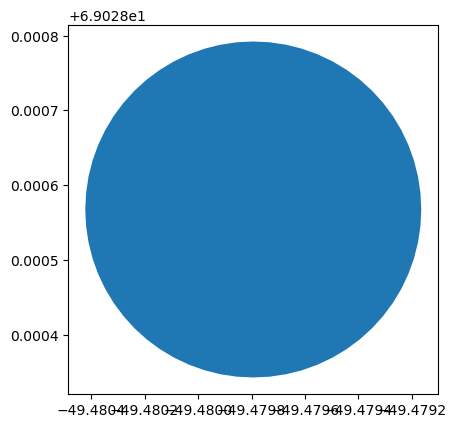

In [19]:
search_circle_gdf.plot()

In [20]:
search_circle_gdf.explore()

In [21]:
#print(p)

'PROJCS["WGS 84 / NSIDC Sea Ice Polar Stereographic North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Polar_Stereographic"],PARAMETER["latitude_of_origin",70],PARAMETER["central_meridian",-30],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]]'

In [22]:
#from pyproj import Transformer